# Task 0: Load model

In [1]:
from TransformerBeta import *
import torch.nn as nn
import numpy as np
import os 
import matplotlib.pyplot as plt

In [2]:
# 0.1 load the model
model_path = "model_M_23Apr10_0108PM" # <------------------------------------------------------------------------change

query_size, key_size, value_size, num_hiddens = 512, 512, 512, 512
num_layers, dropout = 6, 0.2
lr, training_steps, batch_size, label_smoothing = 0.0004, 300000, 4096, 0.1
ffn_num_input, ffn_num_hiddens, num_heads = 512, 2048, 8

norm_shape = [512] # 512 corresponds to the dim of such number to normalize
device = d2l.try_gpu()

encoder_standard = TransformerEncoder(
	len(amino_dict), key_size, query_size, value_size, num_hiddens, 
	norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
	num_layers, dropout)
decoder_standard = TransformerDecoder(
	len(amino_dict), key_size, query_size, value_size, num_hiddens, 
	norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
	num_layers, dropout, shared_embedding=encoder_standard.embedding)
model_standard = EncoderDecoder(encoder_standard, decoder_standard)

model_standard_total_params = sum(p.numel() for p in model_standard.parameters())
model_standard_total_trainable_params = sum(p.numel() for p in model_standard.parameters() if p.requires_grad)

state_dict = torch.load(model_path,map_location=('cpu'))
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
	name = k[7:] #remove 'module'
	new_state_dict[name] = v

model_standard.load_state_dict(new_state_dict)

model_use = model_standard # <------------------------------------------------------------------------change
prediction_length = 8 # <------------------------------------------------------------------------change

# 0.2 create a txt file to record the results
if not os.path.exists('model_prediction'):
	os.mkdir('model_prediction')
print('Standard model: total number of parameters: {}'.format(model_standard_total_params))
print('Standard model: total number of trainable parameters: {}'.format(model_standard_total_trainable_params))

Standard model: total number of parameters: 44126232
Standard model: total number of trainable parameters: 44126232


# Task 0: Target selection

#### Target of selection

In [18]:
# task_target = 'QPRTFLLK'
# task_target = 'LEILDITP'
# task_target = 'TLEILDIT'
# task_target = 'TLEILDIT'

task_target = 'LCGEDLII'
model_use = model_standard
prediction_length = 8

#### Search Training database

In [19]:
# load training data
train_dict = np.load('train_l8_anti/train_dict_fold0.npy', allow_pickle=True)
train_dict = train_dict.tolist()
train_list = []
for target, value_dict in train_dict.items():
    for comp, count in value_dict.items():
        train_list.append([target, comp, count])
train_array = np.array(train_list)

In [20]:
# dataset same search
print("Training Dataset search result: \n", search_target(train_array, task_target))

Training Dataset search result: 
 []


In [21]:
# dataset similar search
print("Training Dataset similar search result: \n", search_target_similar(train_array, task_target, insimilarity_num=2))

Training Dataset similar search result: 
 [['LCGVDLII' 'LVVVRYDK' '7' '1']
 ['ICGIDLII' 'LVFFRYET' '71' '2']
 ['ICGIDLII' 'IVFFRYET' '15' '2']
 ['VCGVDLII' 'LVFFRYET' '262' '2']
 ['VCGVDLII' 'LTFFRYET' '17' '2']
 ['VCGVDLII' 'IVFFRYET' '17' '2']
 ['VCGVDLII' 'LIFFRYET' '18' '2']
 ['ACGVDLII' 'LIFFRYET' '163' '2']
 ['ACGVDLII' 'LVFFRYET' '101' '2']
 ['LVGVDLII' 'VLTARFLY' '5' '2']]


# Task 0: Target prediction 

#### Greedy single prediction

In [22]:
dec_comple_peptide_pred, dec_prob, dec_attention_weight_seq = predict_greedy_single(model_use, task_target, amino_dict, prediction_length + 2, device, save_attention_weights=True, print_info=True)

Conditional probability at position 1 is 0.3478420078754425
Conditional probability at position 2 is 0.2842143177986145
Conditional probability at position 3 is 0.6428002119064331
Conditional probability at position 4 is 0.871859073638916
Conditional probability at position 5 is 0.33799993991851807
Conditional probability at position 6 is 0.21431304514408112
Conditional probability at position 7 is 0.4287305176258087
Conditional probability at position 8 is 0.6121038794517517
Input target sequence is LCGEDLII, predicted complementary peptide is IYLLGVKF
Condition on input, predicted probability is 0.0010532344244075565


#### Candidate single sampling

In [23]:
peptide_candidates = sample_single_candidate(model_use, task_target, amino_dict, prediction_length + 2, device)
print(peptide_candidates)

number of total candidates sampled: 1
number of unique top candidates successfully sampled: 1
[['LLFGRRER' '4.845338480663486e-06']]


#### Candidates sampling

In [24]:
num_candidates = 10000
max_iter = 20

peptide_candidates = sample_candidates(model_use, task_target, num_candidates, amino_dict, prediction_length + 2, device, max_iter=max_iter)
# add a reverse column if antiparallel
sythesis_pep = np.array([string[::-1] for string in peptide_candidates[:, 0]])
peptide_candidates = np.concatenate((peptide_candidates, sythesis_pep.reshape(-1, 1)), axis=1)

print(peptide_candidates[:10])

number of total candidates sampled: 20000
number of unique top candidates successfully sampled: 10000
[['ITFSEGNL' '0.0017162164440378547' 'LNGESFTI']
 ['IYLLRVDR' '0.0013529649004340172' 'RDVRLLYI']
 ['IYLLRVDK' '0.0013323077000677586' 'KDVRLLYI']
 ['IHLDVGNL' '0.001111157238483429' 'LNGVDLHI']
 ['IYLLGVKF' '0.0010532384039834142' 'FKVGLLYI']
 ['IYLLRVKF' '0.0007420199108310044' 'FKVRLLYI']
 ['IYLLGIKF' '0.0007337715360336006' 'FKIGLLYI']
 ['IVLLRVSL' '0.0006154404254630208' 'LSVRLLVI']
 ['IYLLRVDL' '0.0006154276197776198' 'LDVRLLYI']
 ['LTFSEGNL' '0.0005980731220915914' 'LNGESFTL']]


In [25]:
# !!!!!!!!!!!!!!!!! do not run this cell
# save peptide candidates as a txt file in a model prediction folder
if not os.path.exists('model_prediction'):
	os.mkdir('model_prediction')
with open('model_prediction/{}_{}candidates.txt'.format(task_target, num_candidates), 'w') as f:
	for i in range(len(peptide_candidates)):
		f.write(peptide_candidates[i][0] + '\t' + str(peptide_candidates[i][1]) + '\t' + str(peptide_candidates[i][2]) + '\n')

#### Peptides pair evaluation

In [24]:
task_target = task_target
dec_comple_peptide_pred = 'IYLLRVDK'

dec_prob, dec_attention_weight_seq = evaluate_single(model_use, task_target, dec_comple_peptide_pred,amino_dict, prediction_length + 2, device, save_attention_weights=True, print_info=True)

Conditional probability at position 1 is 0.3478420078754425
Conditional probability at position 2 is 0.2842143177986145
Conditional probability at position 3 is 0.6428002119064331
Conditional probability at position 4 is 0.871859073638916
Conditional probability at position 5 is 0.3062882423400879
Conditional probability at position 6 is 0.7048718333244324
Conditional probability at position 7 is 0.45221075415611267
Conditional probability at position 8 is 0.24630385637283325
Input target sequence is LCGEDLII, complementary peptide is IYLLRVDK
Evaluated probability is 0.0013323025673110283


# Task 0: Read save data for analysis

In [26]:
# task_target = 'QPRTFLLK'
# task_target = 'LEILDITP'
# task_target = 'TLEILDIT'
task_target = 'LCGEDLII'
num_candidates = 10000

# read peptide candidates from a txt file in a model prediction folder
with open('model_prediction/{}_{}candidates.txt'.format(task_target, num_candidates), 'r') as f:
    peptide_candidates = []
    for line in f:
        peptide_candidates.append(line.strip().split('\t'))
peptide_candidates = np.array(peptide_candidates)

# Task 1: Hamming_distance_against_training

In [ ]:
task_hamming_dict = {}
num_data_run = 500
num_folds = 20
for fold_num in range(0, num_folds):
    task_hamming_dict_fold = np.load('train_l8_anti/{}_training_hamming_distance_dict_fold'.format(task_target)+str(fold_num)+'.npy', allow_pickle=True)
    task_hamming_dict_fold = task_hamming_dict_fold.tolist()
    for batch_num, data_dict in task_hamming_dict_fold.items():
        task_hamming_dict[batch_num+fold_num*num_data_run] = data_dict

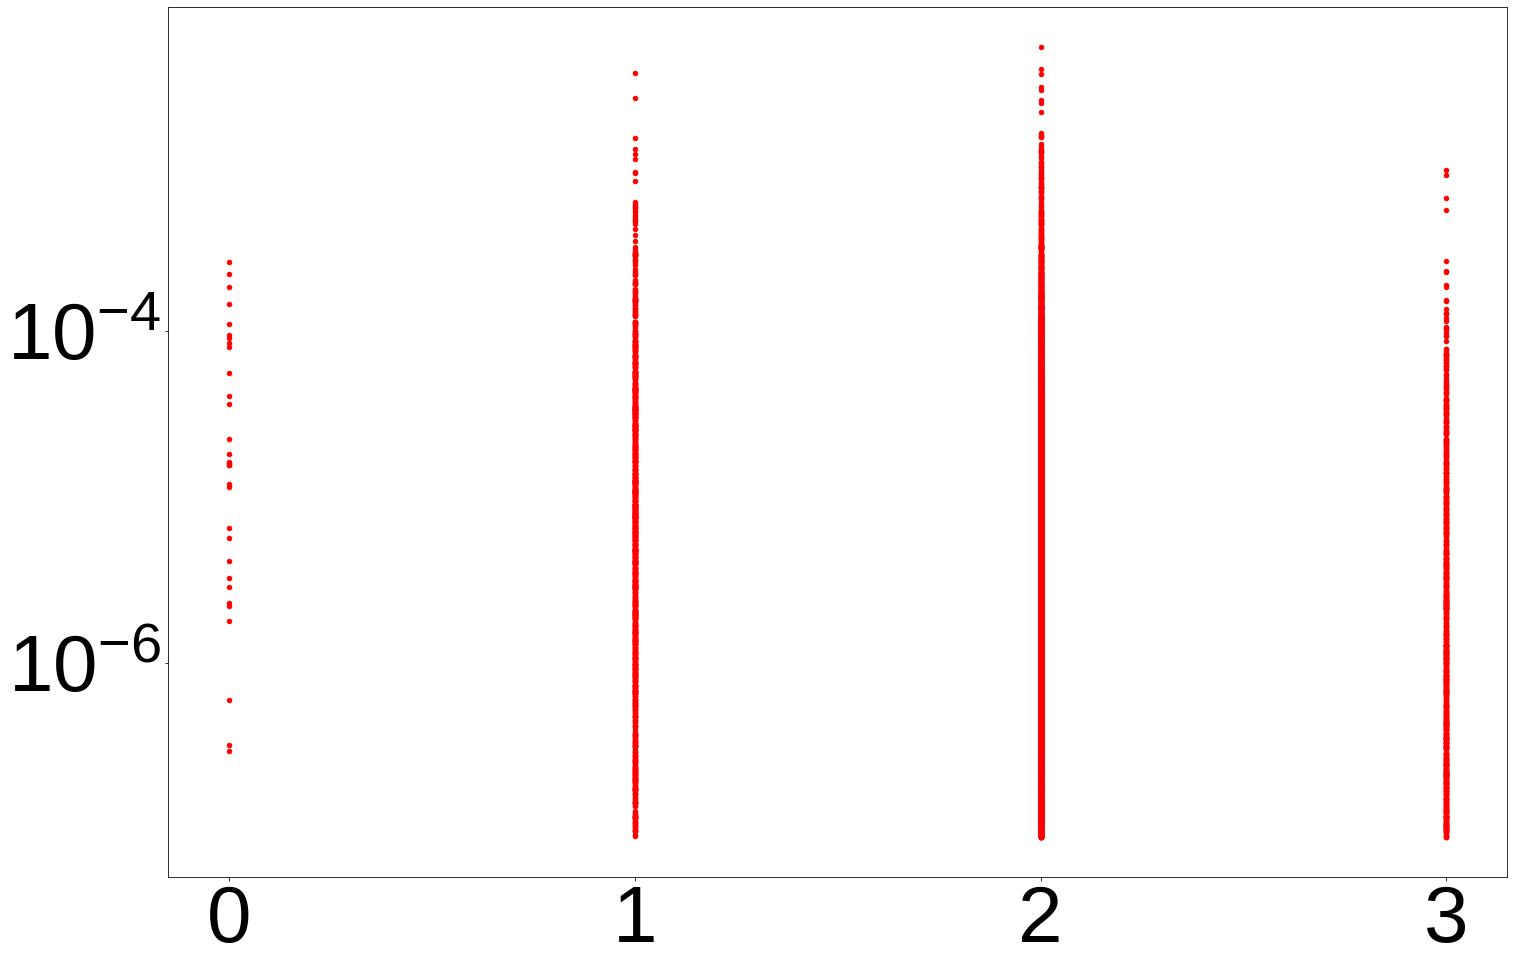

In [118]:
# plot a scatter plot of the prob vs minimal hamming distance (minial key value of the dict)
font_size = 80 

plt.rcParams.update({
    'font.size': font_size,
    'font.family': 'Liberation Sans',
    'lines.linewidth': 8,
})

plt.figure(figsize=(24, 16), facecolor=(1, 1, 1))
minimum_hamming_distance = []
for i in range(len(peptide_candidates)):
    minimum_hamming_distance.append(min(task_hamming_dict[i].keys()))
plt.scatter(minimum_hamming_distance, peptide_candidates[:, 1].astype(float), s=20, c='r', marker='o')
# plt.xlabel('Hamming Distance')
# plt.ylabel('Evaluated Probability')
plt.xticks(np.arange(min(minimum_hamming_distance), max(minimum_hamming_distance)+1, 1.0))  # Set x-tick values to integers
plt.yscale('log')  # Set y-axis to log scale
# plt.savefig('model_prediction/hamming_vs_prob_{}_{}.png'.format(task_target, num_candidates), bbox_inches='tight')
# plt.savefig('model_evaluation/adobe_plots/hamming_vs_prob_{}_{}.png'.format(task_target, num_candidates), bbox_inches='tight')
plt.show()

In [119]:
from collections import defaultdict

def plot_box_plot(minimum_hamming_distance, probabilities, filename):
    plt.rcParams.update({
        'font.size': 80,
        'font.family': 'Liberation Sans',
    })

    plt.figure(figsize=(24, 16), facecolor=(1, 1, 1))

    # Group probabilities by hamming distances
    grouped_probs = defaultdict(list)
    for dist, prob in zip(minimum_hamming_distance, probabilities):
        grouped_probs[dist].append(prob)
    
    # Prepare data for boxplot
    distances = sorted(list(grouped_probs.keys()))
    box_plot_data = []
    for dist in distances:
        data = grouped_probs[dist]
        box_plot_data.append(data)
        print(f'Hamming distance {dist}: {len(data)} data points')

    # Create the box plot
    bp = plt.boxplot(box_plot_data, positions=range(len(distances)), widths=0.5, showfliers=True, patch_artist=True)

    # Set box colors
    colors = ['blue'] * len(distances)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    # Set the median line style and color
    for median in bp['medians']:
        median.set(color='black', linewidth=3)

    # Set the x-axis labels
    plt.xticks(range(len(distances)), distances)

    # Set the y-axis to log scale
    plt.gca().set_yscale('log')

    plt.grid(True)

    # Save the plot
    plt.savefig('model_evaluation/adobe_plots/{}'.format(filename), bbox_inches='tight')

    # Show the plot
    plt.show()

Hamming distance 0: 31 data points
Hamming distance 1: 1241 data points
Hamming distance 2: 7864 data points
Hamming distance 3: 864 data points


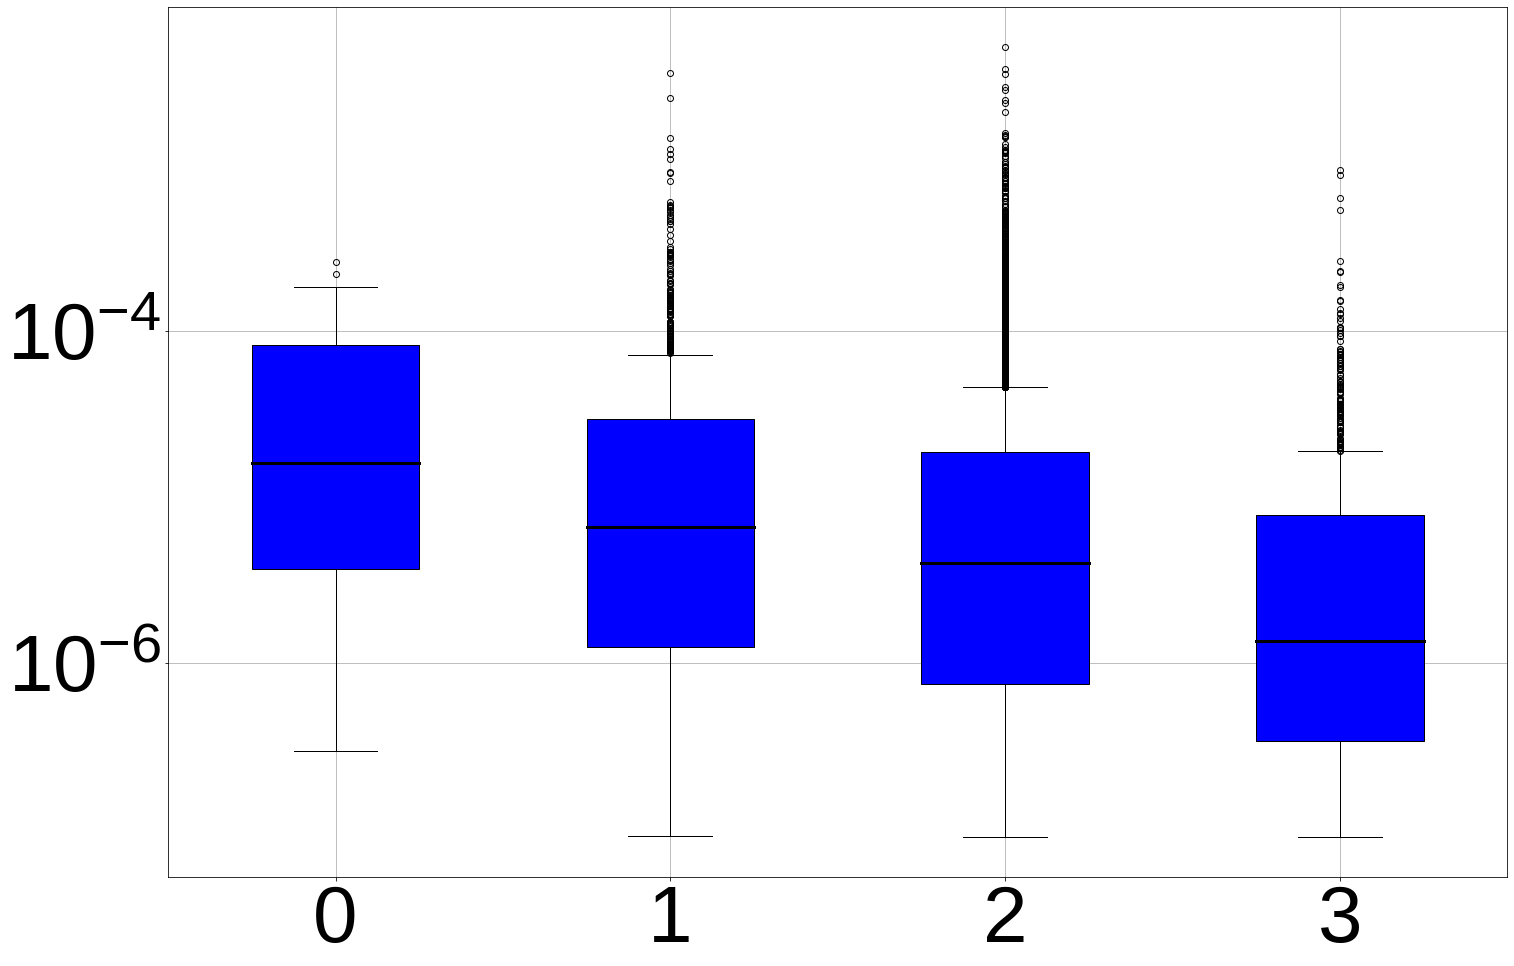

In [120]:
minimum_hamming_distance = []
for i in range(len(peptide_candidates)):
    minimum_hamming_distance.append(min(task_hamming_dict[i].keys()))
plot_box_plot(minimum_hamming_distance, peptide_candidates[:, 1].astype(float), 'hamming_vs_prob_{}_{}.png'.format(task_target, num_candidates))

# Task 2: Hamming_distance_against_top1_prediction

In [90]:
# calculate the hamming distance between peptide candidates and the top 1 in peptide candidates
top1_hamming_distance = []
top1_peptide = peptide_candidates[0][0]

def hamming_distance(s1, s2):
    assert len(s1) == len(s2)
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))

for i in range(len(peptide_candidates)):
    top1_hamming_distance.append(hamming_distance(top1_peptide, peptide_candidates[i][0]))
    if i%1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


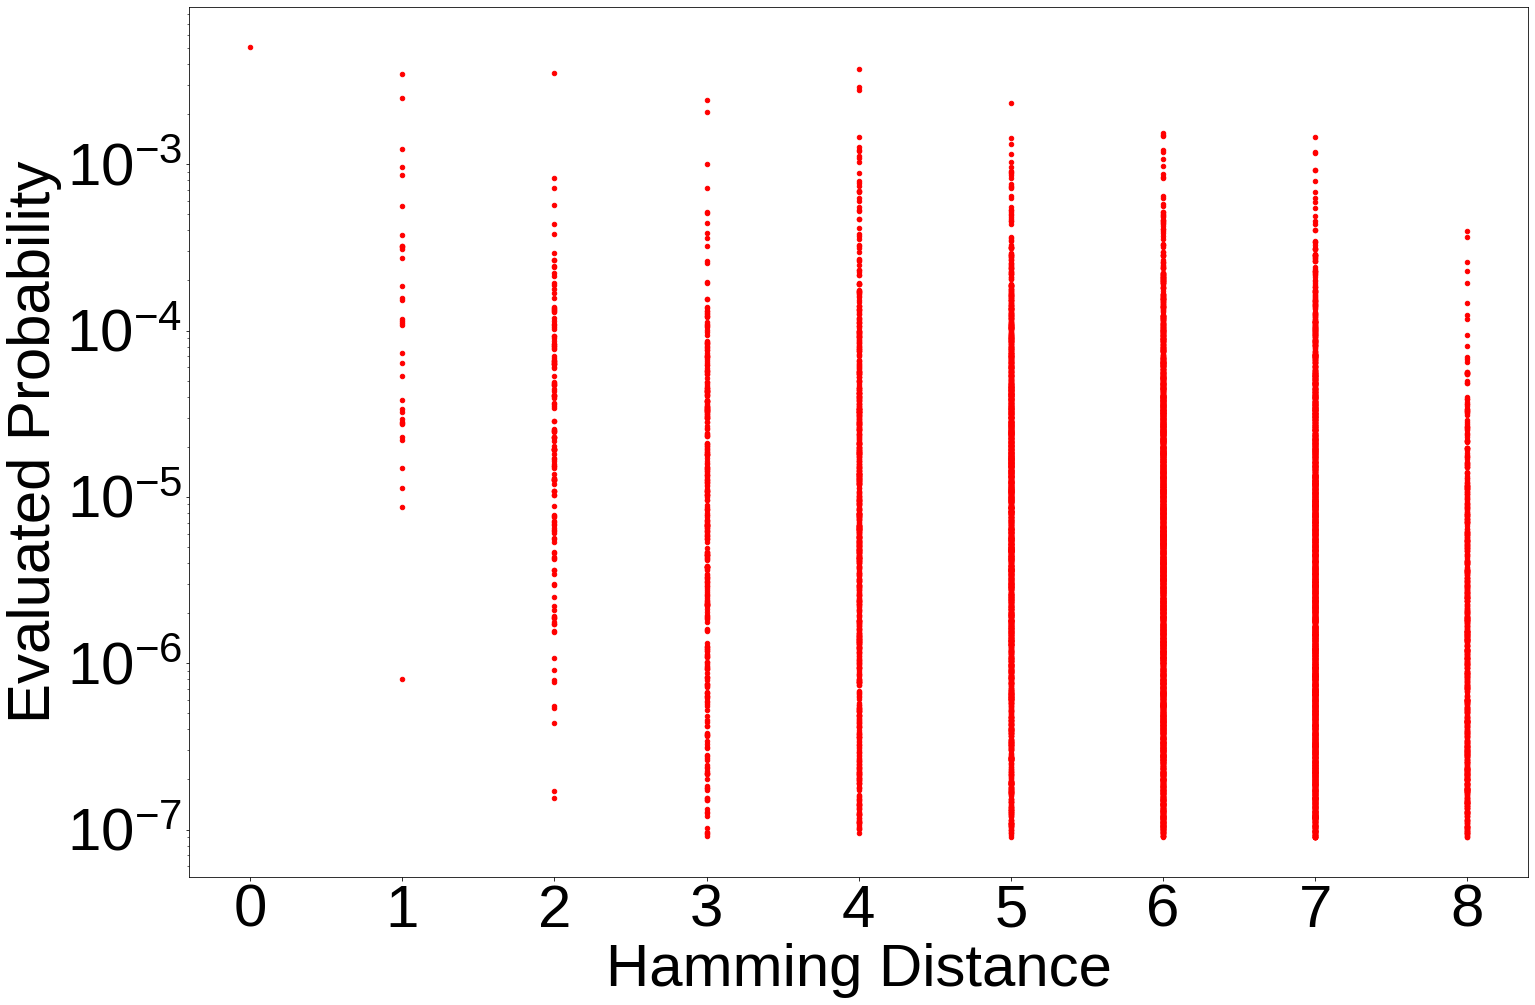

In [91]:
# plot a scatter plot of the prob vs hamming distance between peptide candidates and the top 1 in peptide candidates
font_size = 60

plt.rcParams.update({
	'font.size': font_size,
	'font.family': 'Liberation Sans',
	'lines.linewidth': 3,
})

plt.figure(figsize=(24, 16), facecolor=(1, 1, 1))
plt.scatter(top1_hamming_distance, peptide_candidates[:, 1].astype(float), s=20, c='r')
plt.xlabel('Hamming Distance')
plt.ylabel('Evaluated Probability')
plt.xticks(np.arange(min(top1_hamming_distance), max(top1_hamming_distance)+1, 1.0))  # Set x-tick values to integers
plt.yscale('log')  # Set y-axis to log scale
plt.savefig('model_prediction/hamming_vs_prob_{}_{}_top1.png'.format(task_target, num_candidates), bbox_inches='tight')
plt.show()

# Task 3: Clustering the peptides by K-medoids + silhouette score

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn_extra.cluster import KMedoids 
import scipy.spatial.distance as ssd
from sklearn.metrics import silhouette_score

font_size = 80

In [97]:
# K-medoids
peptide_candidates_num, peptide_candidates_num_copy = seq2num(peptide_candidates[:, 0], peptide_candidates[:, 0], amino_dict)

# Calculate the pairwise Hamming distance matrix
condensed_distance_matrix = ssd.pdist(peptide_candidates_num, 'hamming')
distance_matrix = ssd.squareform(condensed_distance_matrix)

# Run K-medoids clustering with different numbers of clusters and store the silhouette scores
silhouette_scores = []
max_clusters = 50  # You can adjust this depending on the desired range of cluster numbers to test
for i in range(2, max_clusters + 1):  # Start from 2 clusters as silhouette score is not defined for 1 cluster
    kmedoids = KMedoids(n_clusters=i, init='k-medoids++', random_state=42, metric='precomputed')
    kmedoids.fit(distance_matrix)
    cluster_labels = kmedoids.labels_
    silhouette_avg = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
    silhouette_scores.append(silhouette_avg)

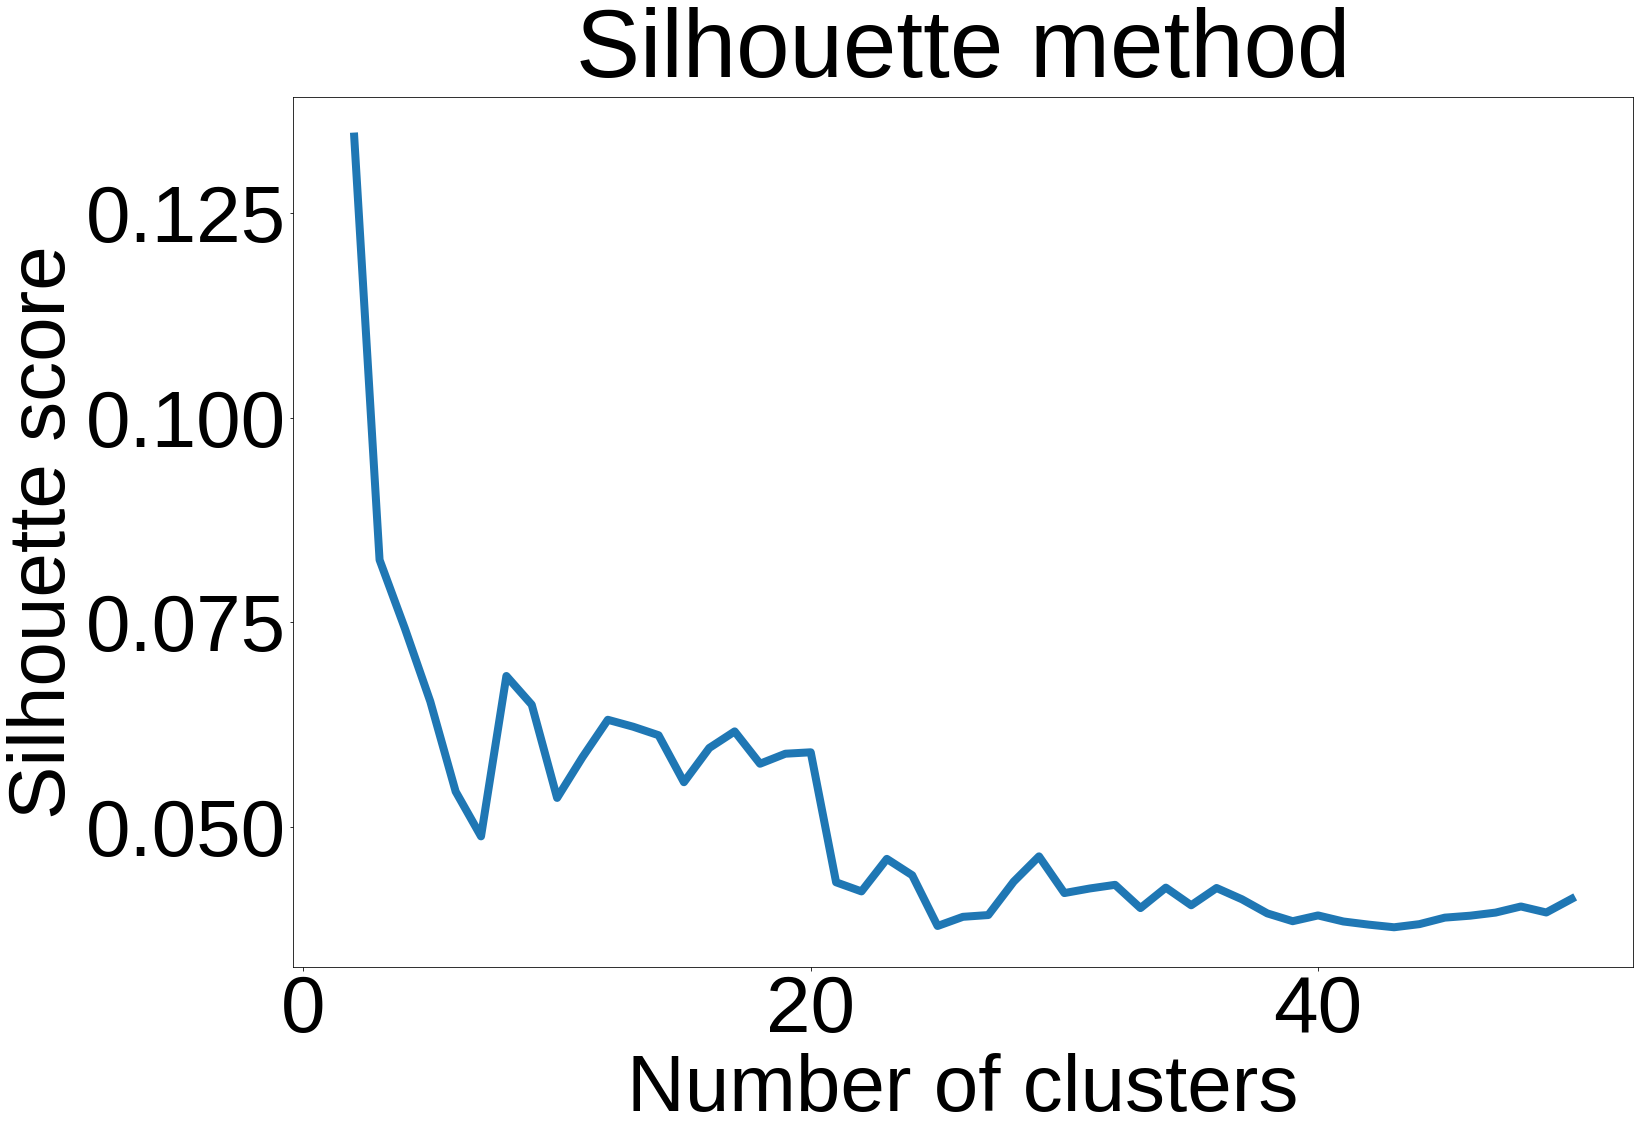

In [98]:
# Plot the silhouette scores curve
plt.rcParams.update({
    'font.size': font_size,
    'font.family': 'Liberation Sans',
    'lines.linewidth': 8,
})

plt.figure(figsize=(24, 16), facecolor=(1, 1, 1))
plt.plot(range(2, max_clusters + 1), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette method')
plt.show()

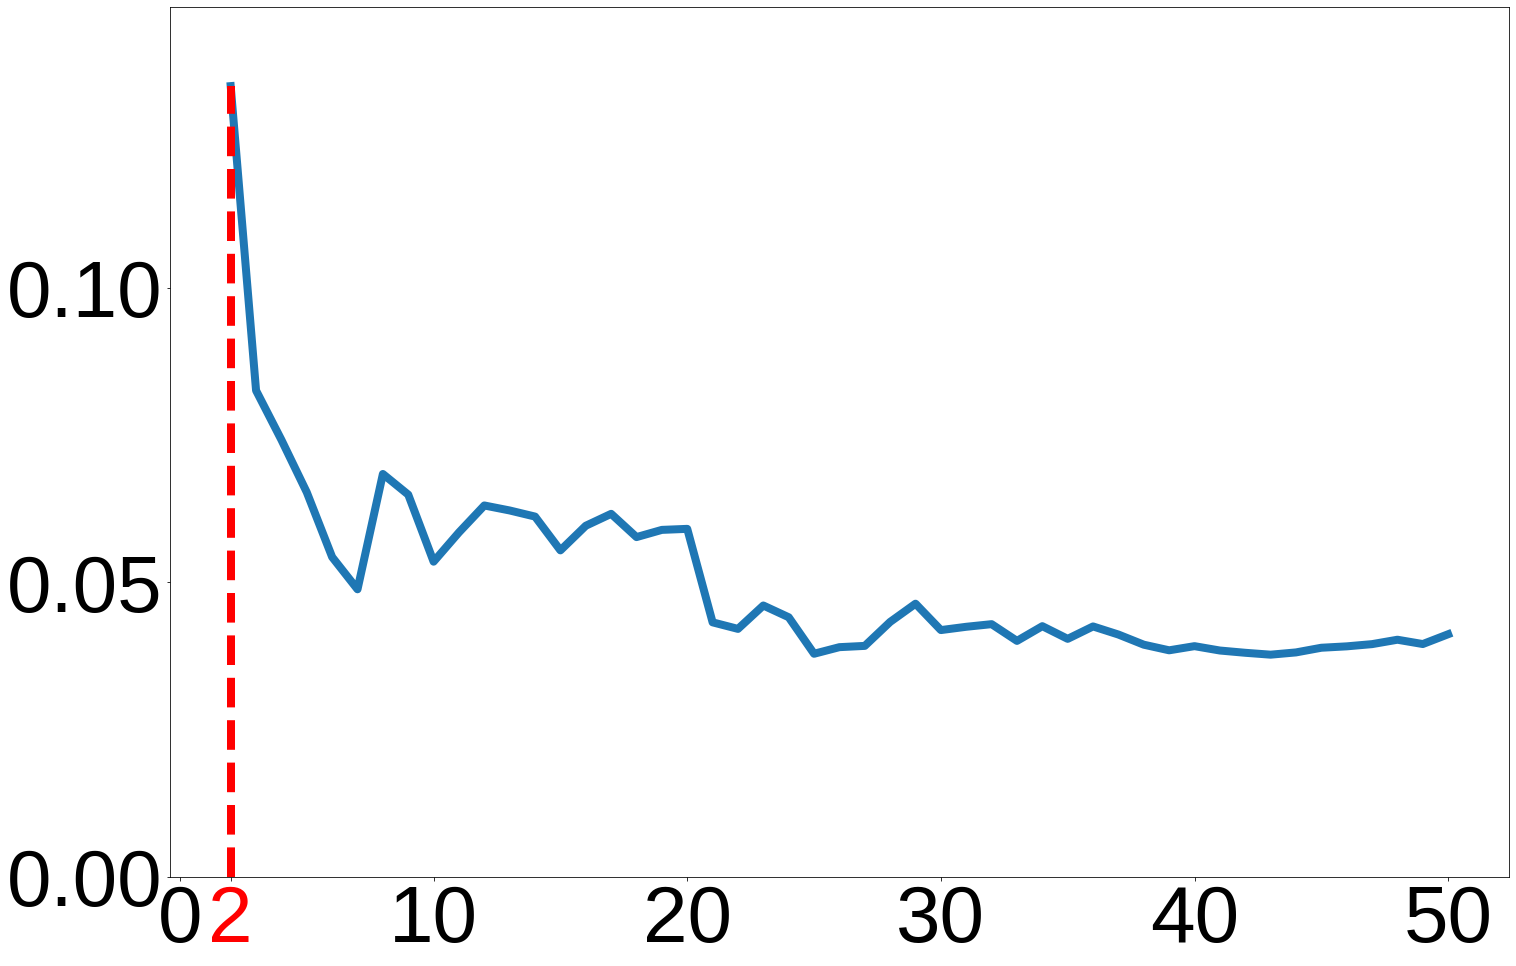

In [99]:
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2

# Plot the silhouette scores curve
fig, ax = plt.subplots(figsize=(24, 16), facecolor=(1, 1, 1))
ax.plot(range(2, max_clusters + 1), silhouette_scores)

# Draw a dotted red line from the optimal cluster point on the x-axis to the curve
ax.plot([optimal_clusters, optimal_clusters], [0, silhouette_scores[optimal_clusters - 2]], color='red', linestyle='--', clip_on=True)

# Set y-axis limit to avoid the red line going outside the graph
ax.set_ylim(0, max(silhouette_scores) * 1.1)

# Set x-tick labels with the optimal cluster labeled and other labels at an interval of 10
x_tick_labels = list(range(0, max_clusters + 1, 10))
x_tick_labels.insert(x_tick_labels.index((optimal_clusters // 10) * 10) + 1, optimal_clusters)
ax.set_xticks(x_tick_labels)
ax.set_xticklabels([str(x) if x != optimal_clusters else f'{optimal_clusters}' for x in x_tick_labels])

# Get the x-tick labels and set the color of the optimal cluster label to red
xtick_labels = ax.get_xticklabels()
xtick_labels[x_tick_labels.index(optimal_clusters)].set_color('red')

# plt.xlabel('Number of clusters')
# plt.ylabel('Silhouette Scores')
# plt.title('Silhouette Scores Method')
# plt.savefig('model_prediction/clustering_kmedoids_silhouette_{}_{}.png'.format(task_target, num_candidates), bbox_inches='tight')
plt.savefig('model_evaluation/adobe_plots/clustering_kmedoids_silhouette_{}_{}.png'.format(task_target, num_candidates), bbox_inches='tight')
plt.show()

In [100]:
# Perform K-medoids clustering with the optimal number of clusters
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
kmedoids = KMedoids(n_clusters=optimal_clusters, init='k-medoids++', random_state=42, metric='precomputed')
cluster_labels = kmedoids.fit_predict(distance_matrix)

# Perform t-SNE dimensionality reduction using the precomputed Hamming distance matrix
tsne = TSNE(n_components=2, random_state=42, perplexity=30, metric='precomputed')
peptide_candidates_tsne = tsne.fit_transform(distance_matrix)

/rds/general/user/hz3519/home/anaconda3/envs/UROP_transformer/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/rds/general/user/hz3519/home/anaconda3/envs/UROP_transformer/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


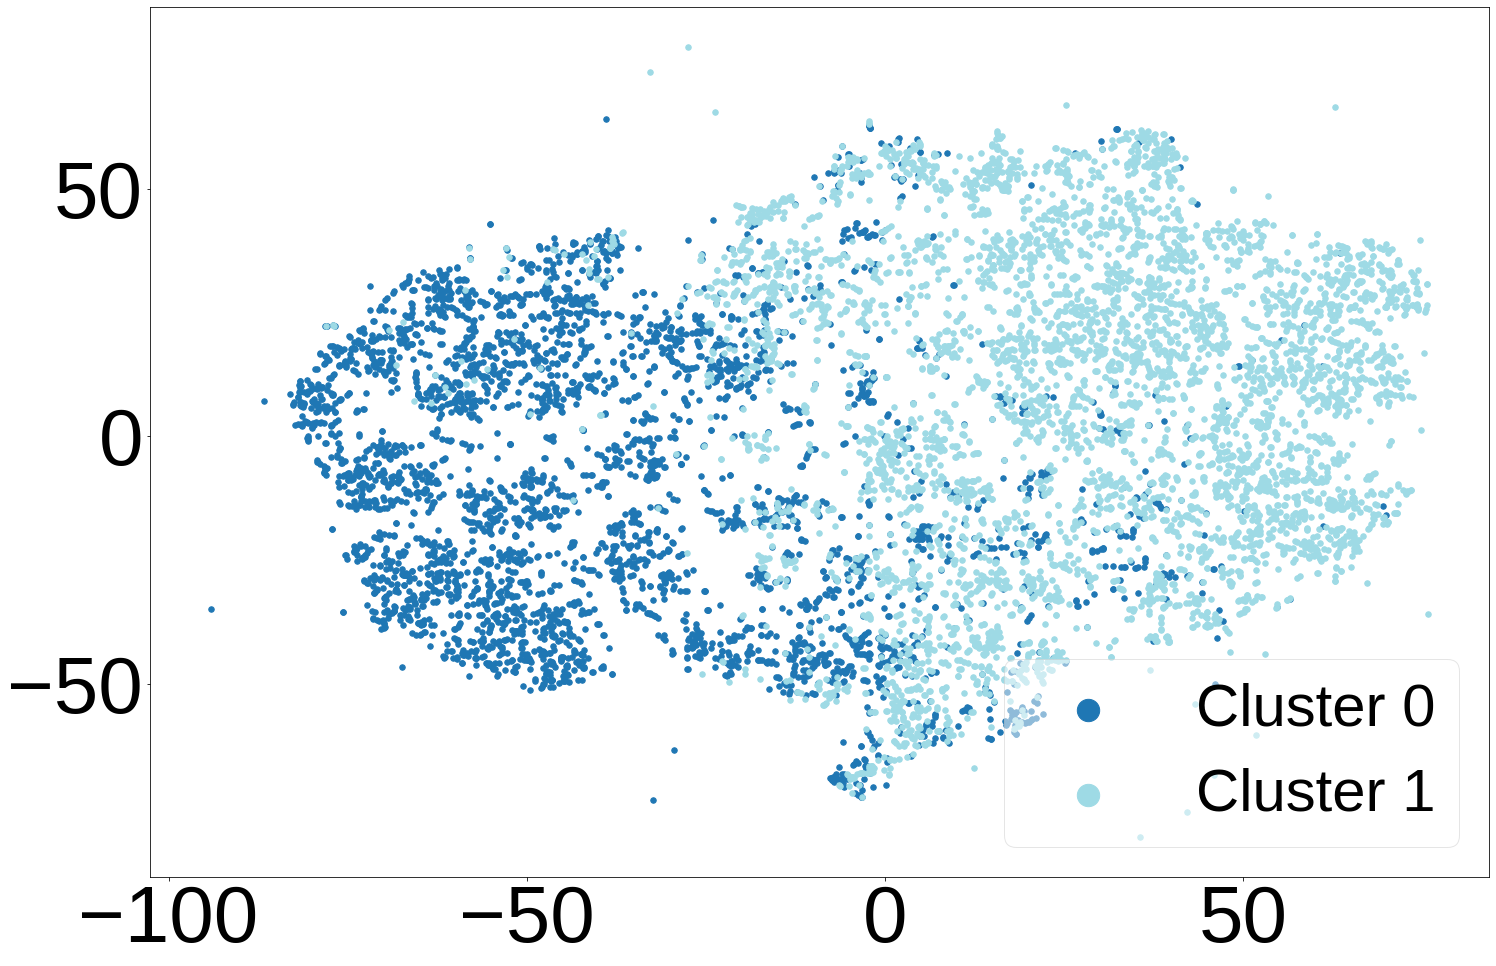

In [101]:
# Plot the clusters
plt.figure(figsize=(24, 16), facecolor=(1, 1, 1))
cmap = plt.cm.get_cmap('tab20', optimal_clusters)  # Color map with enough colors for the optimal number of clusters

for i in range(optimal_clusters):
    plt.scatter(peptide_candidates_tsne[cluster_labels == i, 0], peptide_candidates_tsne[cluster_labels == i, 1], s=30, c=[cmap(i)], label=f'Cluster {i}')

# Get current legend
legend = plt.legend(loc='lower right', fontsize=60, framealpha=0.5)

# Set legend marker size
legend_handle_size = 500  # You can adjust this value as needed
for handle in legend.legendHandles:
    handle._sizes = [legend_handle_size]

# plt.title('t-SNE visualization of peptide clusters')
# plt.xlabel('t-SNE 1')
# plt.ylabel('t-SNE 2')
# plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.03))
# plt.savefig('model_prediction/clustering_kmedoids_tsne_{}_{}.png'.format(task_target, num_candidates), bbox_inches='tight')
plt.savefig('model_evaluation/adobe_plots/clustering_kmedoids_tsne_{}_{}.png'.format(task_target, num_candidates), bbox_inches='tight')
plt.show()

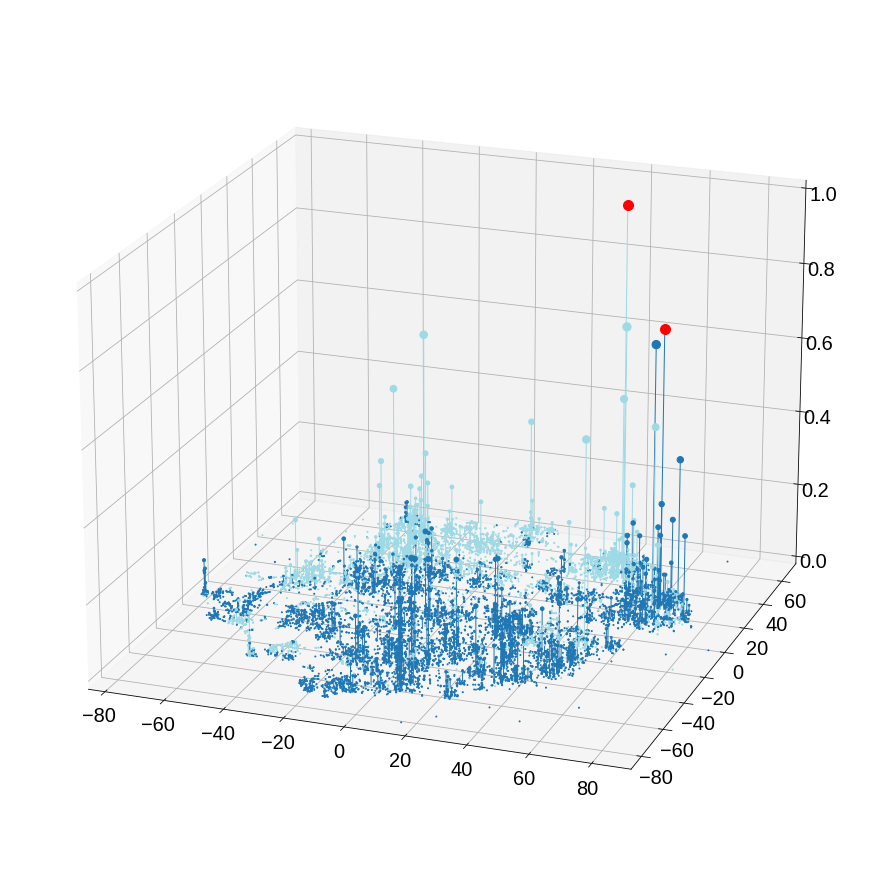

In [41]:
# Scale the x and y coordinates for better visualization
scaling_factor = 1  # You can adjust this factor based on your needs
x = peptide_candidates_tsne[:, 0] * scaling_factor
y = peptide_candidates_tsne[:, 1] * scaling_factor

# Calculate the third coordinate using the probability values from peptide_candidates
z = peptide_candidates[:, 1].astype(float)

# Normalize the probability values for better visualization
z_normalized = (z - np.min(z)) / (np.max(z) - np.min(z))

# Calculate the size of the scatter points based on their probabilities
min_size = 1  # You can adjust the minimum size of the points
max_size = 100  # You can adjust the maximum size of the points
sizes = min_size + z_normalized * (max_size - min_size)

# Find the indices of the peptides with the highest probability in each cluster
highest_prob_indices = []
for i in range(optimal_clusters):
    cluster_indices = np.where(cluster_labels == i)[0]
    highest_prob_index = cluster_indices[np.argmax(peptide_candidates[cluster_labels == i, 1].astype(float))]
    highest_prob_indices.append(highest_prob_index)

# Create a 3D scatter plot
font_size = 40
plt.rcParams.update({
    'font.size': 20,
    'font.family': 'Liberation Sans',
    'lines.linewidth': 3,
})

fig = plt.figure(figsize=(24, 16), facecolor=(1, 1, 1))
ax = fig.add_subplot(111, projection='3d')

# Define the colors for each cluster
colors = [cmap(cluster) for cluster in cluster_labels]

# Plot the points with colors based on their cluster assignments and sizes based on their probabilities
x_remove = []
y_remove = []
z_remove = []
color_remove = []
size_remove = []
for i, (x_coord, y_coord, z_coord, color, size) in enumerate(zip(x, y, z_normalized, colors, sizes)):
    if i not in highest_prob_indices:
        x_remove.append(x_coord)
        y_remove.append(y_coord)
        z_remove.append(z_coord)
        color_remove.append(color)
        size_remove.append(size)
                
ax.scatter(x_remove, y_remove, z_remove, c=color_remove, s=size_remove, alpha = 1)

for i, (x_coord, y_coord, z_coord, color, size) in enumerate(zip(x, y, z_normalized, colors, sizes)):
    if i in highest_prob_indices:
        ax.scatter(x_coord, y_coord, z_coord, color='red', s=max_size, alpha = 1)
    ax.plot([x_coord, x_coord], [y_coord, y_coord], [0, z_coord], c=color, lw=1, alpha = 1)

# ax.set_xlabel('t-SNE 1', fontsize = font_size, labelpad=30)
# ax.set_ylabel('t-SNE 2', fontsize = font_size, labelpad=30)
# ax.set_zlabel('Normalized Probability', fontsize = font_size, labelpad=30)

ax.set_xlim(min(x), max(x))
ax.set_ylim(min(y), max(y))
ax.set_zlim(min(z_normalized), max(z_normalized))

elevation_angle = 20  # You can adjust the elevation angle (in degrees)
azimuth_angle = -70  # You can adjust the azimuth angle (in degrees)
ax.view_init(elevation_angle, azimuth_angle)

# plt.title('3D Probability Distribution Plot', fontsize = 35, pad=5)

# plt.savefig('model_prediction/clustering_kmedoids_3dprob_{}_{}.png'.format(task_target, num_candidates), bbox_inches='tight')
plt.savefig('model_evaluation/adobe_plots/clustering_kmedoids_3dprob_{}_{}.png'.format(task_target, num_candidates), bbox_inches='tight')
plt.show()

In [140]:
# print the peptide with the highest probability in each cluster
representative_peptides = []
for i in range(optimal_clusters):
    print("cluster {}:".format(i+1))
    print(peptide_candidates[cluster_labels == i][np.argmax(peptide_candidates[cluster_labels == i, 1].astype(float))])
    representative_peptides.append(peptide_candidates[cluster_labels == i][np.argmax(peptide_candidates[cluster_labels == i, 1].astype(float))][0:2])
representative_peptides = np.array(representative_peptides)

cluster 1:
['NYNNQKCF' '0.008857485838234425' 'FCKQNNYN']
cluster 2:
['PQVTVLEL' '0.009370697662234306' 'LELVTVQP']


In [141]:
# load training data
train_dict = np.load('train_l8_anti/train_dict_fold0.npy', allow_pickle=True)
train_dict = train_dict.tolist()
train_list = []
for target, value_dict in train_dict.items():
    for comp, count in value_dict.items():
        train_list.append([target, comp, count])
train_array = np.array(train_list)

In [142]:
# calculate the novelty score for each representative peptide in each cluster, it is defined the shortest distance between the representative peptide and each peptide in the training set
novelty_scores = []
for i in range(optimal_clusters):
    print("cluster {}:".format(i+1))
    print(representative_peptides[i])
    train_peptides = train_array[:, 1]
    peptide_search = representative_peptides[i, 0]
    min_dist = 100
    for pep_num, train_peptide in enumerate(train_peptides):
        for j in range(len(peptide_search)):
            dist = 0
            for k in range(len(peptide_search)):
                if peptide_search[k] != train_peptide[k]:
                    dist += 1
            if dist < min_dist:
                min_dist = dist
        if dist <= 1:
            print("similar training data pair: {}, novelty score: {}".format(train_array[pep_num, :], dist))
    print("minimal distance from training: ", min_dist)
    novelty_scores.append(min_dist)
novelty_scores = np.array(novelty_scores)

cluster 1:
['NYNNQKCF' '0.008857485838234425']
similar training data pair: ['LESLITVP' 'NYSNQKCF' '5'], novelty score: 1
similar training data pair: ['MESLLVMP' 'NYNTQKCF' '10'], novelty score: 1
similar training data pair: ['MDSLVVTP' 'NYSNQKCF' '14'], novelty score: 1
similar training data pair: ['MESLVVVP' 'NYNNQKCF' '5'], novelty score: 0
similar training data pair: ['MESLIVTP' 'NYSNQKCF' '7'], novelty score: 1
similar training data pair: ['MSSLVVEP' 'NYNNQKVF' '31'], novelty score: 1
similar training data pair: ['MESLLVTP' 'NYNTQKCF' '6'], novelty score: 1
similar training data pair: ['MESLLVAP' 'NYNTQKCF' '31'], novelty score: 1
similar training data pair: ['MESLIVVP' 'NFNNQKCF' '36'], novelty score: 1
similar training data pair: ['MESLQVTP' 'NYSNQKCF' '6'], novelty score: 1
minimal distance from training:  0
cluster 2:
['PQVTVLEL' '0.009370697662234306']
similar training data pair: ['FKIYESKV' 'PQVTLLEL' '11'], novelty score: 1
similar training data pair: ['LKVLDLAP' 'PQVTVLEL' 

In [143]:
# save the representative peptides and their novelty scores
representative_peptides_noveltyscores = np.concatenate((representative_peptides, novelty_scores.reshape(-1, 1)), axis=1)
# rank the representative peptides based on their probability values which are the second column in the peptide_candidates array
representative_peptides_noveltyscores = representative_peptides_noveltyscores[np.argsort(representative_peptides_noveltyscores[:, 1])[::-1]]
print(representative_peptides_noveltyscores)
np.savetxt('model_prediction/clustering_kmedoids_selected_{}_{}.txt'.format(task_target, num_candidates), representative_peptides_noveltyscores, fmt='%s')

[['PQVTVLEL' '0.009370697662234306' '0']
 ['NYNNQKCF' '0.008857485838234425' '0']]


# Additional Task 1: Hamming distance check wrt PDB Training

In [3]:
task_target = 'QPRTFLLK'
# task_target = 'LEILDITP'
# task_target = 'TLEILDIT'
num_candidates = 10000

# read peptide candidates from a txt file in a model prediction folder
with open('model_prediction/{}_{}candidates.txt'.format(task_target, num_candidates), 'r') as f:
    peptide_candidates = []
    for line in f:
        peptide_candidates.append(line.strip().split('\t'))
peptide_candidates = np.array(peptide_candidates)

In [5]:
task_hamming_dict = {}
task_hamming_dict = np.load('model_prediction/{}_BSn_hamming_distance_dict'.format(task_target)+'.npy', allow_pickle=True)
task_hamming_dict = task_hamming_dict.tolist()

In [22]:
task_hamming_dict[10]

{7: 17562, 8: 29279, 4: 53, 6: 4188, 5: 628, 3: 4}

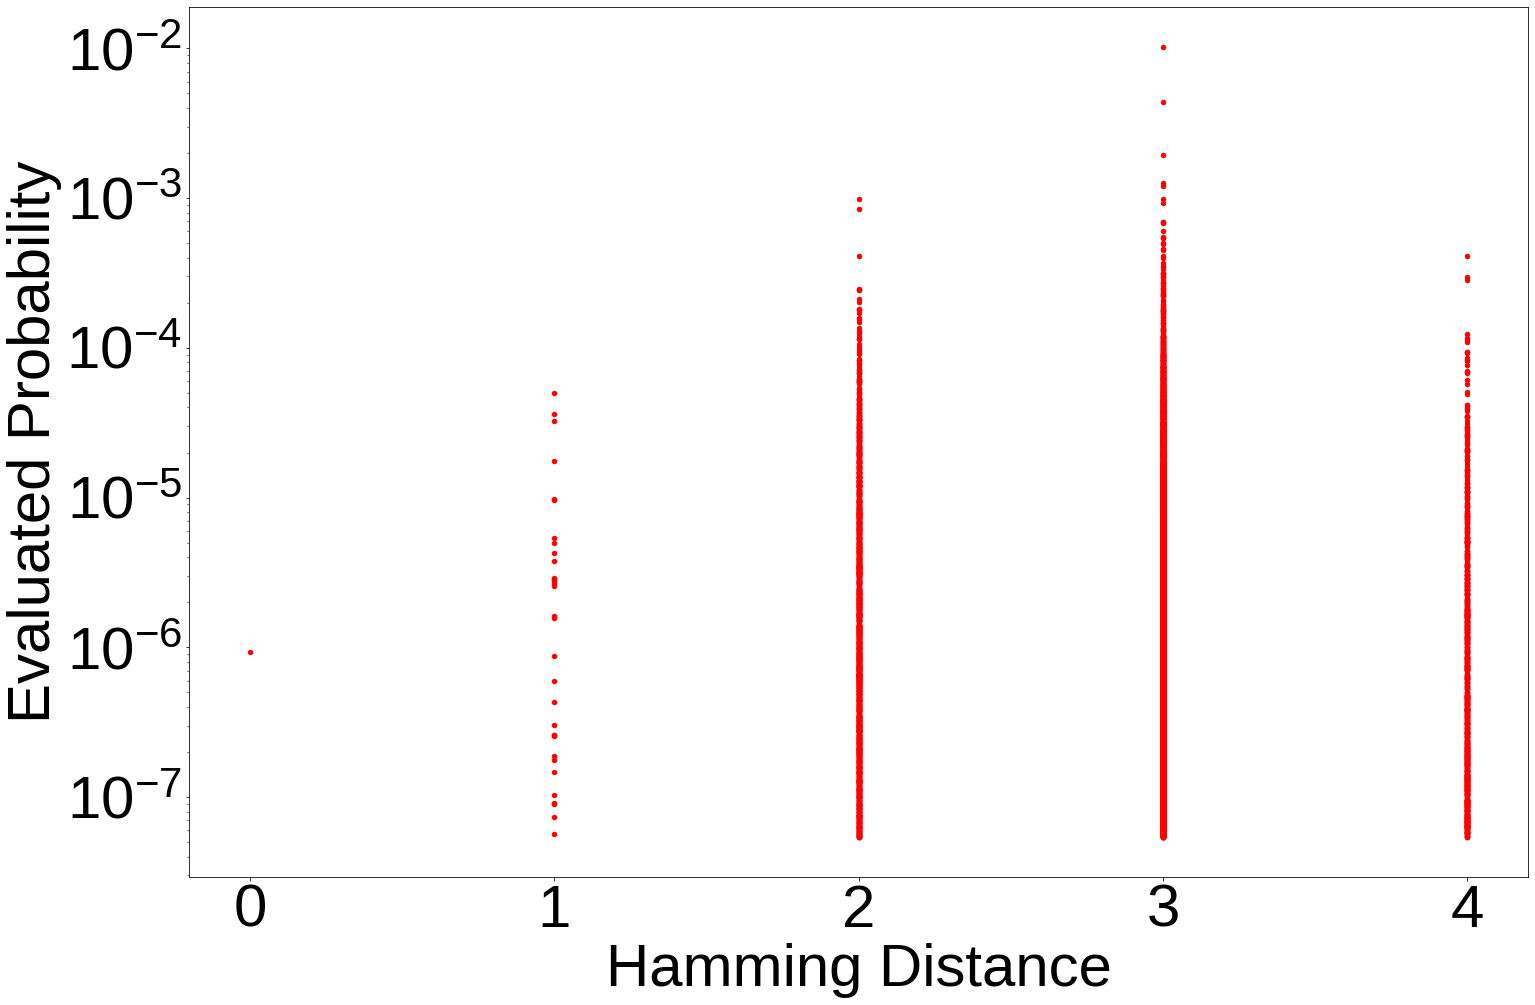

In [15]:
# plot a scatter plot of the prob vs minimal hamming distance (minial key value of the dict)
font_size = 60 

plt.rcParams.update({
    'font.size': font_size,
    'font.family': 'Liberation Sans',
    'lines.linewidth': 3,
})

plt.figure(figsize=(24, 16), facecolor=(1, 1, 1))
minimum_hamming_distance = []
for i in range(len(peptide_candidates)):
    minimum_hamming_distance.append(min(task_hamming_dict[i].keys()))
plt.scatter(minimum_hamming_distance, peptide_candidates[:, 1].astype(float), s=20, c='r')
plt.xlabel('Hamming Distance')
plt.ylabel('Evaluated Probability')
plt.xticks(np.arange(min(minimum_hamming_distance), max(minimum_hamming_distance)+1, 1.0))  # Set x-tick values to integers
plt.yscale('log')  # Set y-axis to log scale
# plt.savefig('model_prediction/hamming_vs_prob_{}_{}.png'.format(task_target, num_candidates), bbox_inches='tight')
plt.show()

# Additional Task 2: test for transformer on BSn

In [48]:
import pickle
import numpy as np
import torch
import torch.nn as nn
from d2l import torch as d2l
import os

from TransformerBeta import *
import warnings
warnings.filterwarnings("ignore", message="mybio.py module not found")
warnings.filterwarnings("ignore", message="zyggregator not found!!!")

"""---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------"""
"""Data preprocessing"""

amino_dict = {
		'<bos>': 0, 
		'<eos>': 1, 
		'<pad>': 2, 
		'<unk>': 3,
		'A': 4,
		'C': 5,
		'D': 6, 
		'E': 7,
		'F': 8, 
		'G': 9, 
		'H': 10,
		'I': 11, 
		'K': 12, 
		'L': 13, 
		'M': 14, 
		'N': 15, 
		'P': 16, 
		'Q': 17, 
		'R': 18, 
		'S': 19, 
		'T': 20, 
		'V': 21, 
		'W': 22, 
		'Y': 23 
		}


# load generated data for target sequence QPRTFLLK, 10000 generated sequences
task_target = 'QPRTFLLK'
num_candidates = 10000

# read peptide candidates from a txt file in a model prediction folder
with open('model_prediction/{}_{}candidates.txt'.format(task_target, num_candidates), 'r') as f:
    peptide_candidates = []
    for line in f:
        peptide_candidates.append(line.strip().split('\t'))
peptide_candidates = np.array(peptide_candidates)

data_list_antiparallel= []
data_list_parallel= []

for i in range(1, 9):
	with open('BSn_libraries/BSn_libraries_copy/anti_frag_dic_{}.pkl'.format(i), 'rb') as f:
		data = pickle.load(f, encoding='latin1')
		data_list_antiparallel.append(data)

	with open('BSn_libraries/BSn_libraries_copy/para_frag_dic_{}.pkl'.format(i), 'rb') as f:
		data = pickle.load(f, encoding='latin1')
		data_list_parallel.append(data)

# target, complementary_seq, counts, promiscuity, length, working_score, hb_pattern, para/anti, freq
BSn_data = []
least_length = 3

for frag_i_data in data_list_parallel[least_length-1:]:
	for keys in frag_i_data.keys():

		length = len(keys)
		freq = len(frag_i_data[keys])
		for element in frag_i_data[keys]:

			working_score = length**2 * element.count_score - 0.01 * length * element.promiscuity_score
			list_i = [keys, element.complementary_sequence, element.count_score, element.promiscuity_score, length, working_score, element.hb_pattern, 0, freq]
			BSn_data.append(list_i)

for frag_i_data in data_list_antiparallel[least_length-1:]:
	for keys in frag_i_data.keys():

		length = len(keys)
		freq = len(frag_i_data[keys])
		for element in frag_i_data[keys]:

			working_score = length**2 * element.count_score - 0.01 * length * element.promiscuity_score
			list_i = [keys, element.complementary_sequence, element.count_score, element.promiscuity_score, length, working_score, element.hb_pattern, 1, freq]
			BSn_data.append(list_i)

# target, complementary_seq, counts, promiscuity, length, working_score, hb_pattern, para/anti, freq

BSn_data_dataset_sequence = np.array(BSn_data, dtype=object)
BSn_data_dataset2 = np.array(BSn_data_dataset_sequence)

target_indices = np.arange(BSn_data_dataset2.shape[0]).reshape(-1, 1)
BSn_data_dataset2_indices = np.hstack([BSn_data_dataset2, target_indices])

condition1 = np.nonzero(np.array([len(sequence)==8 for sequence in BSn_data_dataset2_indices[:, 0]]))
BSn_data_dataset2_indices_length8 = BSn_data_dataset2_indices[condition1]

BSn_target = BSn_data_dataset2_indices_length8[:, 0]
BSn_complementary = BSn_data_dataset2_indices_length8[:, 1]

In [3]:
# load training data
train_dict = np.load('train_l8_anti/train_dict_fold0.npy', allow_pickle=True)
train_dict = train_dict.tolist()
train_list = []
for target, value_dict in train_dict.items():
    for comp, count in value_dict.items():
        train_list.append([target, comp, count])
train_array = np.array(train_list)

In [89]:
print(BSn_data_dataset2_indices_length8[:20, :5])

[['RCGSDFLV' 'TFIRVGTC' 1 0 8]
 ['ETVRIALV' 'AKVEICWV' 1 0 8]
 ['GTIGIAIP' 'LDFVLATA' 1 0 8]
 ['HHFAHNDL' 'VLRHNTST' 1 0 8]
 ['ELTVNILT' 'KWNAVALW' 1 4 8]
 ['GVKYITKA' 'YFDVVEEI' 1 0 8]
 ['TVDTQLKV' 'TAHSDYEI' 1 1 8]
 ['VVLAGEIT' 'VLVAYDKQ' 1 0 8]
 ['MSVINFEC' 'TYFFTWDT' 1 0 8]
 ['VSVVWIGD' 'LATDVIIR' 1 0 8]
 ['SVLSCVEQ' 'LILVLGEI' 1 0 8]
 ['TVDVTFIN' 'TVHVVAAA' 1 0 8]
 ['SIEVNIEA' 'GVKIKAEK' 1 0 8]
 ['CFIYNVKI' 'TYKVYMSG' 1 0 8]
 ['RTISHVGL' 'NFVTVDAL' 1 0 8]
 ['AVLSAIGK' 'MVLVGGEI' 1 0 8]
 ['KMMSIGMH' 'VAVQFVLN' 1 0 8]
 ['FIYKVKLL' 'FKVHMEGS' 1 3 8]
 ['GFMTTIHS' 'LDGVSIRV' 1 0 8]
 ['GFMTTIHS' 'LDGVAIRV' 1 0 8]]


In [127]:
task_target = 'GMAVAVIY'
model_use = model_standard
prediction_length = 8

In [129]:
# dataset search
print("Training Dataset search result: \n", search_target(train_array, task_target))
print("BSn Dataset search result: \n", search_target(BSn_data_dataset2_indices_length8, task_target))

Training Dataset search result: 
 [['GMAVAVIY' 'GFTFYHPQ' '211']
 ['GMAVAVIY' 'GYTFFWPK' '5']
 ['GMAVAVIY' 'GWTFYYPK' '962']
 ['GMAVAVIY' 'GFTYYHSK' '22']
 ['GMAVAVIY' 'GWTFYYRQ' '7']
 ['GMAVAVIY' 'GFTYYHPK' '112']
 ['GMAVAVIY' 'GFTFYYPK' '5']
 ['GMAVAVIY' 'GYNFFQPK' '7']
 ['GMAVAVIY' 'GWTFYYPQ' '16']
 ['GMAVAVIY' 'GYTFYYPK' '12']
 ['GMAVAVIY' 'GWTFYLPY' '10']
 ['GMAVAVIY' 'GFTFYHPK' '6']
 ['GMAVAVIY' 'GFTFYYPQ' '5']
 ['GMAVAVIY' 'GYSFYYPT' '6']]
BSn Dataset search result: 
 [['GMAVAVIY' 'GFTYYHPK' 1 0 8 64.0
  ((None, None), (0, 0), (None, None), (0, 0), (None, None), (0, 0), (None, None), (0, 0))
  1 3 2187356]
 ['GMAVAVIY' 'GFTFYHPQ' 1 0 8 64.0
  ((None, None), (0, 0), (None, None), (0, 0), (None, None), (0, 0), (None, None), (0, 0))
  1 3 2187357]
 ['GMAVAVIY' 'GWTFYYPK' 1 1 8 63.92
  ((None, None), (0, 0), (None, None), (0, 0), (None, None), (0, 0), (None, None), (0, 0))
  1 3 2187358]]


In [130]:
# dataset similar search
print("Training Dataset similar search result: \n", search_target_similar(train_array, task_target, insimilarity_num=2))

Training Dataset similar search result: 
 [['GMAIGVIY' 'GYYKEYSK' '12' '2']
 ['GVAVAVSY' 'GFGRAYVL' '6' '2']
 ['GTAVAVIH' 'GYGKQWIV' '6' '2']
 ['GMAVAVLV' 'GWTFYYPK' '5' '2']
 ['GMAVAVFK' 'GYNFYHPQ' '12' '2']
 ['GMAVAGIY' 'GWTFYYPK' '6' '1']
 ['GMAVAVTY' 'GYNFYHRQ' '6' '1']
 ['GMAVAVAV' 'GYNFVYRR' '6' '2']
 ['GMAVGVID' 'GYNYVYPK' '6' '2']
 ['GMASAVIY' 'PISGTLML' '9' '1']
 ['GMAVQVTY' 'KLFLVNVG' '5' '2']
 ['GMAVAVIY' 'GFTFYHPQ' '211' '0']
 ['GMAVAVIY' 'GYTFFWPK' '5' '0']
 ['GMAVAVIY' 'GWTFYYPK' '962' '0']
 ['GMAVAVIY' 'GFTYYHSK' '22' '0']
 ['GMAVAVIY' 'GWTFYYRQ' '7' '0']
 ['GMAVAVIY' 'GFTYYHPK' '112' '0']
 ['GMAVAVIY' 'GFTFYYPK' '5' '0']
 ['GMAVAVIY' 'GYNFFQPK' '7' '0']
 ['GMAVAVIY' 'GWTFYYPQ' '16' '0']
 ['GMAVAVIY' 'GYTFYYPK' '12' '0']
 ['GMAVAVIY' 'GWTFYLPY' '10' '0']
 ['GMAVAVIY' 'GFTFYHPK' '6' '0']
 ['GMAVAVIY' 'GFTFYYPQ' '5' '0']
 ['GMAVAVIY' 'GYSFYYPT' '6' '0']
 ['GMAVAVSV' 'GYNFYYPK' '122' '2']
 ['GMAVAVSV' 'GYDIFFRE' '12' '2']
 ['GMAVAVSV' 'GYHWFHTE' '17' '2']
 ['GMAVAVVH' 'GFGK

In [131]:
dec_comple_peptide_pred, dec_prob, dec_attention_weight_seq = predict_greedy_single(model_use, task_target, amino_dict, prediction_length + 2, device, save_attention_weights=True, print_info=True)

Conditional probability at position 1 is 0.9425057172775269
Conditional probability at position 2 is 0.35627204179763794
Conditional probability at position 3 is 0.9065725207328796
Conditional probability at position 4 is 0.9195989370346069
Conditional probability at position 5 is 0.9219260811805725
Conditional probability at position 6 is 0.8656190037727356
Conditional probability at position 7 is 0.9414014220237732
Conditional probability at position 8 is 0.7258471846580505
Conditional probability at position 9 is 0.9286602139472961
Input target sequence is GMAVAVIY, predicted complementary peptide is GFTFYYPK
Condition on input, predicted probability is 0.14176418243989192


In [133]:
task_target = task_target
dec_comple_peptide_pred = 'GWTFYYPK'

dec_prob, dec_attention_weight_seq = evaluate_single(model_use, task_target, dec_comple_peptide_pred,amino_dict, prediction_length + 2, device, save_attention_weights=True, print_info=True)

Conditional probability at position 1 is 0.9425057172775269
Conditional probability at position 2 is 0.2989218235015869
Conditional probability at position 3 is 0.9412888288497925
Conditional probability at position 4 is 0.9393360614776611
Conditional probability at position 5 is 0.9358329176902771
Conditional probability at position 6 is 0.7744567394256592
Conditional probability at position 7 is 0.94016033411026
Conditional probability at position 8 is 0.5513967275619507
Conditional probability at position 9 is 0.9287092685699463
Input target sequence is GMAVAVIY, complementary peptide is GWTFYYPK
Evaluated probability is 0.08692143452788148


# Additional Task 3: Tianji cascade and Evobind

In [3]:
# task_target = 'QPRTFLLK'
# task_target = 'TLEILDIT'
# task_target = 'LEILDITP'

# second column to be reversed 
data_cascade = [['QPRTFLLK', 'YALLRLYK'], ['QPRTFLLK', 'IALLRLYK'], ['LEILDITP', 'GIVKVYRK'], ['LEILDITP', 'GIVKVYKA'], ['TLEILDIT', 'NYSYIKVS'], ['TLEILDIT', 'TIPLVRFR']]
data_evobind = [['QPRTFLLK', 'LGFFQEFV'], ['QPRTFLLK', 'LGFFQMKV'], ['LEILDITP', 'CLMRAIMV'], ['LEILDITP', 'CLCTCIMV'], ['TLEILDIT', 'GLCGNAII'], ['TLEILDIT', 'GLCGNKII']]

data_to_use = data_cascade + data_evobind

# reverse the second column
for i in range(len(data_to_use)):
    data_to_use[i][1] = data_to_use[i][1][::-1]
data_to_use = np.array(data_to_use)

target_array = data_to_use[:, 0]
comp_array = data_to_use[:, 1]

model_use = model_standard
prediction_length = 8

In [4]:
num_minibatch = 5
cascade_peptide_eval = evaluate_minibatch(model_use, target_array, comp_array, amino_dict, prediction_length + 2, device, num_minibatch=num_minibatch)
print("minibatch evaluatiion number: \n", len(cascade_peptide_eval))
print("minibatch evaluatiion: \n", cascade_peptide_eval)

minibatch evaluatiion number: 
 12
minibatch evaluatiion: 
 [['QPRTFLLK' 'KYLRLLAY' '7.127343160107102e-11']
 ['QPRTFLLK' 'KYLRLLAI' '8.519037905663218e-12']
 ['LEILDITP' 'KRYVKVIG' '9.854167856053822e-15']
 ['LEILDITP' 'AKYVKVIG' '1.1734879154555802e-14']
 ['TLEILDIT' 'SVKIYSYN' '9.695608031712322e-12']
 ['TLEILDIT' 'RFRVLPIT' '4.983395363034049e-10']
 ['QPRTFLLK' 'VFEQFFGL' '1.5938364858599993e-14']
 ['QPRTFLLK' 'VKMQFFGL' '3.9086179496987394e-13']
 ['LEILDITP' 'VMIARMLC' '2.0817836387035382e-13']
 ['LEILDITP' 'VMICTCLC' '9.595009655511896e-14']
 ['TLEILDIT' 'IIANGCLG' '4.811880670936748e-14']
 ['TLEILDIT' 'IIKNGCLG' '2.55081925634032e-13']]


In [5]:
# rank the peptides based on their probability values (the third column in the cascade_peptide_eval array)
# Convert the third column (strings of numbers) to float
cascade_peptide_eval_num = cascade_peptide_eval[:, 2].astype(np.float64)

# Rank the peptides based on their probability values from highest to lowest
cascade_peptide_eval = cascade_peptide_eval[np.argsort(cascade_peptide_eval_num)[::-1]]

# cascade_peptide_eval[:, 2] = np.arange(1, len(cascade_peptide_eval) + 1)
np.savetxt('tianji_peptides.txt', cascade_peptide_eval, fmt='%s')

# Additional Task 4: High prob peptide for Francesco meeting 24/04/2023

In [28]:
# load training data
train_dict = np.load('train_l8_anti/train_dict_fold0.npy', allow_pickle=True)
train_dict = train_dict.tolist()
train_list = []
for target, value_dict in train_dict.items():
    for comp, count in value_dict.items():
        train_list.append([target, comp, count])
train_array = np.array(train_list)

In [32]:
task_target = 'QPRTFLLK'
num_candidates = 10000

# read peptide candidates from a txt file in a model prediction folder
with open('model_prediction/{}_{}candidates.txt'.format(task_target, num_candidates), 'r') as f:
    peptide_candidates = []
    for line in f:
        peptide_candidates.append(line.strip().split('\t'))
peptide_candidates_QPRTFLLK = np.array(peptide_candidates)

task_target = 'LEILDITP'
num_candidates = 10000

# read peptide candidates from a txt file in a model prediction folder
with open('model_prediction/{}_{}candidates.txt'.format(task_target, num_candidates), 'r') as f:
    peptide_candidates = []
    for line in f:
        peptide_candidates.append(line.strip().split('\t'))
peptide_candidates_LEILDITP = np.array(peptide_candidates)

task_target = 'TLEILDIT'
num_candidates = 10000

# read peptide candidates from a txt file in a model prediction folder
with open('model_prediction/{}_{}candidates.txt'.format(task_target, num_candidates), 'r') as f:
    peptide_candidates = []
    for line in f:
        peptide_candidates.append(line.strip().split('\t'))
peptide_candidates_TLEILDIT = np.array(peptide_candidates)

In [33]:
# optional for clusterings
import scipy.spatial.distance as ssd
from sklearn_extra.cluster import KMedoids

# optional for clusterings
def compute_clustering_labels(peptide_candidates, amino_dict, optimal_clusters=2):
    peptide_candidates_num, peptide_candidates_num_copy = seq2num(peptide_candidates, peptide_candidates, amino_dict)

    # Calculate the pairwise Hamming distance matrix
    condensed_distance_matrix = ssd.pdist(peptide_candidates_num, 'hamming')
    distance_matrix = ssd.squareform(condensed_distance_matrix)

    # Compute clustering labels
    kmedoids = KMedoids(n_clusters=optimal_clusters, init='k-medoids++', random_state=42, metric='precomputed')
    cluster_labels = kmedoids.fit_predict(distance_matrix)

    return cluster_labels

cluster_labels_QPRTFLLK = compute_clustering_labels(peptide_candidates_QPRTFLLK[:, 0], amino_dict)
cluster_labels_LEILDITP = compute_clustering_labels(peptide_candidates_LEILDITP[:, 0], amino_dict)
cluster_labels_TLEILDIT = compute_clustering_labels(peptide_candidates_TLEILDIT[:, 0], amino_dict)

In [34]:
# number_to_analyze
num_QPRTFLLK = 50
num_LEILDITP = 20
num_TLEILDIT = 20

peptide_candidates_QPRTFLLK = peptide_candidates_QPRTFLLK[:num_QPRTFLLK]
peptide_candidates_LEILDITP = peptide_candidates_LEILDITP[:num_LEILDITP]
peptide_candidates_TLEILDIT = peptide_candidates_TLEILDIT[:num_TLEILDIT]

In [35]:
# optional for clusterings
cluster_labels_QPRTFLLK = cluster_labels_QPRTFLLK[:num_QPRTFLLK]
cluster_labels_LEILDITP = cluster_labels_LEILDITP[:num_LEILDITP]
cluster_labels_TLEILDIT = cluster_labels_TLEILDIT[:num_TLEILDIT]

In [36]:
import numpy as np
from scipy.stats import percentileofscore
import pandas as pd

def calculate_net_charge(peptide_list, reference_list=None):
    amino_positive = ['R', 'K', 'H']
    amino_negative = ['D', 'E']
    charge_list = []

    for peptide in peptide_list:
        charge = 0
        for amino_acid in peptide:
            if amino_acid in amino_positive:
                charge += 1
            elif amino_acid in amino_negative:
                charge -= 1
        charge_list.append(charge)

    if reference_list is not None:
        reference_charge_list = [calculate_net_charge([ref_seq])[0] for ref_seq in reference_list]
        percentile_list = [percentileofscore(reference_charge_list, charge) for charge in charge_list]
        return charge_list, percentile_list
    else:
        return charge_list
    
kyte_doolittle_scale = {
    'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
    'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
    'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
    'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2
}

def calculate_hydrophobicity(peptide_list, scale, reference_list=None):
    hydrophobicity_list = []

    for peptide in peptide_list:
        hydrophobicity = np.mean([scale[residue] for residue in peptide if residue in scale])
        hydrophobicity_list.append(hydrophobicity)

    if reference_list is not None:
        reference_hydrophobicity_list = calculate_hydrophobicity(reference_list, scale)
        percentile_list = [percentileofscore(reference_hydrophobicity_list, hydrophobicity) for hydrophobicity in hydrophobicity_list]
        return hydrophobicity_list, percentile_list
    else:
        return hydrophobicity_list
    
molecular_weights = {
    'A': 89.094,   # Alanine
    'R': 174.203,  # Arginine
    'N': 132.119,  # Asparagine
    'D': 133.104,  # Aspartic acid
    'C': 121.154,  # Cysteine
    'E': 147.131,  # Glutamic acid
    'Q': 146.146,  # Glutamine
    'G': 75.067,   # Glycine
    'H': 155.156,  # Histidine
    'I': 131.175,  # Isoleucine
    'L': 131.175,  # Leucine
    'K': 146.189,  # Lysine
    'M': 149.208,  # Methionine
    'F': 165.192,  # Phenylalanine
    'P': 115.132,  # Proline
    'S': 105.093,  # Serine
    'T': 119.120,  # Threonine
    'W': 204.228,  # Tryptophan
    'Y': 181.191,  # Tyrosine
    'V': 117.148,  # Valine
}

def calculate_molecular_weights(peptide_list, scale, reference_list=None):
    molecular_weight_list = []

    for peptide in peptide_list:
        molecular_weight = np.mean([scale[residue] for residue in peptide if residue in scale])
        molecular_weight_list.append(molecular_weight)

    if reference_list is not None:
        reference_molecular_weight_list = calculate_molecular_weights(reference_list, scale)
        percentile_list = [percentileofscore(reference_molecular_weight_list, molecular_weight) for molecular_weight in molecular_weight_list]
        return molecular_weight_list, percentile_list
    else:
        return molecular_weight_list
    
from Bio.SeqUtils.ProtParam import ProteinAnalysis

def calculate_isoelectric_points(peptide_list, reference_list=None):
    isoelectric_point_list = []

    for peptide in peptide_list:
        analysis = ProteinAnalysis(peptide)
        isoelectric_point = analysis.isoelectric_point()
        isoelectric_point_list.append(isoelectric_point)

    if reference_list is not None:
        reference_isoelectric_point_list = calculate_isoelectric_points(reference_list)
        percentile_list = [percentileofscore(reference_isoelectric_point_list, isoelectric_point) for isoelectric_point in isoelectric_point_list]
        return isoelectric_point_list, percentile_list
    else:
        return isoelectric_point_list
    
def calculate_aromaticity(peptide_list, reference_list=None):
    aromaticity_list = []

    for peptide in peptide_list:
        analysis = ProteinAnalysis(peptide)
        aromaticity = analysis.aromaticity()
        aromaticity_list.append(aromaticity)

    if reference_list is not None:
        reference_aromaticity_list = calculate_aromaticity(reference_list)
        percentile_list = [percentileofscore(reference_aromaticity_list, aromaticity) for aromaticity in aromaticity_list]
        return aromaticity_list, percentile_list
    else:
        return aromaticity_list
    
def calculate_novelty_scores(peptide_list, reference_list):
    novelty_scores = []

    for peptide_search in peptide_list:
        min_dist = 100
        for train_peptide in reference_list:
            for j in range(len(peptide_search)):
                dist = 0
                for k in range(len(peptide_search)):
                    if peptide_search[k] != train_peptide[k]:
                        dist += 1
                if dist < min_dist:
                    min_dist = dist
        novelty_scores.append(min_dist)

    return np.array(novelty_scores)

def calculate_novelty_scores_and_reference_targets(peptide_list, reference_list, target, target_reference_list):
    novelty_scores = []
    target_novelty_scores = []

    for peptide_search in peptide_list:
        min_dist = 100
        min_dist_indices = []
        for idx, train_peptide in enumerate(reference_list):
            dist = 0
            for k in range(len(peptide_search)):
                if peptide_search[k] != train_peptide[k]:
                    dist += 1
            if dist < min_dist:
                min_dist = dist
                min_dist_indices = [idx]
            elif dist == min_dist:
                min_dist_indices.append(idx)

        novelty_scores.append(min_dist)
        
        min_target_dist = 100
        for idx in min_dist_indices:
            reference_target = target_reference_list[idx]
            target_dist = sum(a != b for a, b in zip(target, reference_target))
            if target_dist < min_target_dist:
                min_target_dist = target_dist

        target_novelty_scores.append(min_target_dist)

    return np.array(novelty_scores), np.array(target_novelty_scores)

import pandas as pd


def generate_output_table(peptide_candidates, peptide_candidates_prob, reference_list, output_file='output_table.xlsx', cluster_labels='', target = None, target_reference_list = None, target_novelty_score = ''):
    print('Clustering analysis Done')
    ranks = np.arange(1, len(peptide_candidates) + 1) 
    print('rank analysis Done')
    charge, charge_percentile = calculate_net_charge(peptide_candidates, reference_list)
    print('Net Charge Analysis Done')
    hydrophobicity, hydrophobicity_percentile = calculate_hydrophobicity(peptide_candidates, kyte_doolittle_scale, reference_list)
    print('Hydrophobicity Analysis Done')
    molecular_weight, molecular_weight_percentile = calculate_molecular_weights(peptide_candidates, molecular_weights, reference_list)
    print('Molecular Weight Analysis Done')
    isoelectric_point, isoelectric_point_percentile = calculate_isoelectric_points(peptide_candidates, reference_list)
    print('Isoelectric Point Analysis Done')
    aromaticity, aromaticity_percentile = calculate_aromaticity(peptide_candidates, reference_list)
    print('Aromaticity Analysis Done')
    if target == None and target_reference_list == None and target_novelty_score == '':
        novelty_score = calculate_novelty_scores(peptide_candidates, reference_list)
        print('Novelty Score Analysis Done')
    else:
        novelty_score, target_novelty_score = calculate_novelty_scores_and_reference_targets(peptide_candidates, reference_list, target, target_reference_list)
        print('Novelty Score and Target Novelty Score Analysis Done')
    # reverse each of the sequence in peptide_candidates
    peptide_candidates_synthesis = [peptide[::-1] for peptide in peptide_candidates]

    data = {
        'Rank': ranks,
        'Cluster Label': cluster_labels,
        'Target Sequence': '',
        'Designed Complementary Peptide': peptide_candidates,
        'Synthesis Complementary Peptide': peptide_candidates_synthesis,
        'Probability': peptide_candidates_prob,
        'Novelty Score': novelty_score,
        'Target Novelty Score': target_novelty_score,
        'CamSol Solubility Score': '',
        'Net Charge': charge,
        'Net Charge Percentile': charge_percentile,
        'Hydrophobicity': hydrophobicity,
        'Hydrophobicity Percentile': hydrophobicity_percentile,
        'Molecular Weight': molecular_weight,
        'Molecular Weight Percentile': molecular_weight_percentile,
        'Isoelectric Point': isoelectric_point,
        'Isoelectric Point Percentile': isoelectric_point_percentile,
        'Aromaticity': aromaticity,
        'Aromaticity Percentile': aromaticity_percentile
    }

    df = pd.DataFrame(data)
    df.to_excel(output_file, index=False)

In [38]:
# Generate output table for QPRTFLLK
target = "QPRTFLLK"
output_file_name = 'model_prediction/output_analysis_{}.xlsx'.format(target)
peptide_candidates = peptide_candidates_QPRTFLLK[:, 0]
peptide_candidates_prob = peptide_candidates_QPRTFLLK[:, 1]
reference_list = train_array[:, 1]
target_reference_list = train_array[:, 0]
generate_output_table(peptide_candidates, peptide_candidates_prob, reference_list, output_file=output_file_name, cluster_labels=cluster_labels_QPRTFLLK, target=target, target_reference_list=target_reference_list,)

# Generate output table for LEILDITP
target = "LEILDITP"
output_file_name = 'model_prediction/output_analysis_{}.xlsx'.format(target)
peptide_candidates = peptide_candidates_LEILDITP[:, 0]
peptide_candidates_prob = peptide_candidates_LEILDITP[:, 1]
reference_list = train_array[:, 1]
target_reference_list = train_array[:, 0]
generate_output_table(peptide_candidates, peptide_candidates_prob, reference_list, output_file=output_file_name, cluster_labels=cluster_labels_LEILDITP, target=target, target_reference_list=target_reference_list,)

# Generate output table for TLEILDIT
target = "TLEILDIT"
output_file_name = 'model_prediction/output_analysis_{}.xlsx'.format(target)
peptide_candidates = peptide_candidates_TLEILDIT[:, 0]
peptide_candidates_prob = peptide_candidates_TLEILDIT[:, 1]
reference_list = train_array[:, 1]
target_reference_list = train_array[:, 0]
generate_output_table(peptide_candidates, peptide_candidates_prob, reference_list, output_file=output_file_name, cluster_labels=cluster_labels_TLEILDIT, target=target, target_reference_list=target_reference_list,)

Clustering analysis Done
rank analysis Done
Net Charge Analysis Done
Hydrophobicity Analysis Done
Molecular Weight Analysis Done
Isoelectric Point Analysis Done
Aromaticity Analysis Done
Novelty Score and Target Novelty Score Analysis Done
Clustering analysis Done
rank analysis Done
Net Charge Analysis Done
Hydrophobicity Analysis Done
Molecular Weight Analysis Done
Isoelectric Point Analysis Done
Aromaticity Analysis Done
Novelty Score and Target Novelty Score Analysis Done
Clustering analysis Done
rank analysis Done
Net Charge Analysis Done
Hydrophobicity Analysis Done
Molecular Weight Analysis Done
Isoelectric Point Analysis Done
Aromaticity Analysis Done
Novelty Score and Target Novelty Score Analysis Done


In [53]:
search_sequence = 'ILRFTVSY'
novelty_score = 3

peptide_search = search_sequence 
reference_list = train_array[:, 1]

for i, train_peptide in enumerate(reference_list):
    for j in range(len(peptide_search)):
        dist = 0
        for k in range(len(peptide_search)):
            if peptide_search[k] == 'x':
                continue
            if peptide_search[k] != train_peptide[k]:
                dist += 1
    if dist <= novelty_score:
        print(train_array[i], dist)

['IYDISYRE' 'ILVCTVKY' '5'] 3
['FIEIRLNG' 'ILRIEVSG' '7'] 3
['MDSRQTVI' 'ILDFSVLY' '18'] 3
['GIKVKANV' 'YLRGTVEY' '7'] 3
['IDDVAMKK' 'AASFTVSY' '5'] 3
['EVCVVTYN' 'ILFSTLSY' '5'] 3
['RAEYGIFI' 'IDRFYVSG' '6'] 3
['VPDRIRVI' 'IVRYTVLY' '5'] 3
['EMKCAVNN' 'KLRSDVSY' '5'] 3
['LDGFEREL' 'ILRLTLPY' '8'] 3
['GDVVGISL' 'LERFTVSY' '6'] 2
['NAWVGLTN' 'ELKFTVST' '9'] 3
['EEIAFLVL' 'IFRFIVLY' '9'] 3
['NAFLEFTY' 'EVRFLVSY' '10'] 3
['QTTIGVSG' 'QLRFNVKY' '5'] 3
['LVRKDGDL' 'ILSFTASY' '6'] 2
['CSYLTVSS' 'ELRFGVSL' '5'] 3
['QATLSLSG' 'ELLFGVSY' '7'] 3
['IKEILINH' 'ITRFTISD' '5'] 3
['QATIGISG' 'QLRFNVKY' '5'] 3
['RVERRCVV' 'SLRFTVKT' '6'] 3
['VAEVVMRL' 'ELTFTVTY' '6'] 3
['ALSVVSIE' 'ILQFFVRY' '5'] 3
['WYLVSYIS' 'INRFAVQY' '5'] 3
['ESILYVNG' 'ELIFGVSY' '5'] 3
['QAYVGMSD' 'ELRFVVSR' '5'] 3
['GAQYRIVG' 'ILRSTVIC' '6'] 3
['RYQGWLNE' 'ELRFFVSK' '6'] 3
['VRPVQVSS' 'RLTFTVSG' '8'] 3
['KLTLQYEL' 'TLRITVSL' '15'] 3
['NLTHVRVL' 'TLDFTVSS' '7'] 3
['VAIAGVSL' 'VTRFTVSY' '5'] 2
['TLYVGRIE' 'LLRFTVRY' '5'] 2
['SMVMT

# Additional task 5: task_target = 'LCGEDLII'